In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1,3,6,7"

In [2]:
import sys
import torch
import pandas as pd
import numpy as np
import random 
from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
sys.path.insert(0,'../src/')
import config, dataset, model, engine, utils, model_parameters

In [4]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(7) 

In [5]:
df_train, df_test = utils.split_data()

In [6]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,news_id,url,title,content,images,tweet_ids,image_list,label,clean_nb_imgs
0,0,984,gossipcop-3507938806,www.foxnews.com/entertainment/2017/07/12/donal...,Donald Trump Jr. releases email exchange: Cele...,Donald Trump Jr. has been making headlines thi...,['fake_gossipcop-3507938806_headshot-48513.jpg...,885131701877428224\t885131769896472577\t885131...,['fake_gossipcop-3507938806_headshot-48513.jpg...,1,3
1,1,1579,gossipcop-8115207261,www.dailystar.co.uk/showbiz/678030/Lady-Gaga-p...,What has Lady Gaga done to her face? Plastic s...,The video will auto-play soon 8 Cancel\n\nSign...,['fake_gossipcop-8115207261_1219768.jpg'],958296018965225472\t958331247956320256\t958343...,['fake_gossipcop-8115207261_1219768.jpg'],1,1
2,2,657,gossipcop-7544598697,www.hollywoodreporter.com/news/oscars-2017-mem...,"Oscars ""In Memoriam"": Garry Shandling, Robert ...","Oscars ""In Memoriam"": Garry Shandling, Robert ...",['fake_gossipcop-7544598697_split_vaughn_shand...,836090741512273921\t836092215893995520\t836098...,['fake_gossipcop-7544598697_split_vaughn_shand...,1,2
3,3,952,gossipcop-3645597267,www.girlfriend.com.au/kourtney-kardashian-blas...,Kourtney Kardashian blasts pregnant sister Khl...,Video from the upcoming season finale of Keepi...,['fake_gossipcop-3645597267_1000-khloe-kourtne...,970403514911358976\t992690721353236482\t102183...,['fake_gossipcop-3645597267_1000-khloe-kourtne...,1,1
4,5,1077,gossipcop-1363170506,pagesix.com/2017/10/31/the-text-that-changed-e...,The text that changed everything for J.Lo and ...,Click to email this to a friend (Opens in new ...,['fake_gossipcop-1363170506_alex-jennifer.jpg'...,966067473316491265\t966071495192702976\t966071...,['fake_gossipcop-1363170506_alex-jennifer.jpg'...,1,2


In [105]:
train_dataset = dataset.FakeNewsDataset(df_train)

# train_data_loader = DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE,
#                         shuffle=True)
## using padding
train_data_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, collate_fn=dataset.MyCollate())



val_dataset = dataset.FakeNewsDataset(df_test)

# val_data_loader = DataLoader(val_dataset, batch_size=config.EVAL_BATCH_SIZE,
#                         shuffle=True)
## using padding
val_data_loader = DataLoader(val_dataset, batch_size=config.EVAL_BATCH_SIZE,
                        shuffle=True, collate_fn=dataset.MyCollate())

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.Multiple_Images_Model()

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

Using 4 GPUs


/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 3. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [10]:
!nvidia-smi

Tue Apr  6 15:55:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:1A:00.0 Off |                  N/A |
| 72%   69C    P2   340W / 350W |  11543MiB / 24268MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 32%   

In [11]:
def sim_loss(x, y):

    centroid = torch.mean(x, dim=1, keepdim=True)

    centroid = centroid.repeat(1, x.size(1), 1)

    y = y.unsqueeze(1).repeat(1, x.size(1))

    batch_size = x.shape[0]

    # Squash samples and timesteps into a single axis
    x_reshape = x.contiguous().view(-1, x.size(-1))  # (b_s * num_components, latent_dim)

    centroid_reshape = centroid.contiguous().view(-1, centroid.size(-1))  # (b_s * num_components, latent_dim)

    dist_mat = config.PDIST(x_reshape, centroid_reshape).view(batch_size, -1)

    total_loss = torch.mean(dist_mat, dim=1)

    return total_loss 

In [12]:
EXP_NAME = "cleaned_GC_padding_exp1"# or exp5 # uncleaned_PF_padding_exp1
MODEL_PATH = f'/media/nas_mount/Shivangi/mudit/log/saved_model/{EXP_NAME}.pt'

In [13]:
loaded_state_dict = torch.load(MODEL_PATH,  map_location=device)

In [14]:
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [15]:
def create_multimodal_space_df():
    cols = ['col_'+str(i) for i in range(1,model_parameters.MULTIMODAL_SPACE_DIM+1)]
    cols_space = cols + ['sample_no', 'label']
    cols_mean = cols + ['cluster_dist', 'label']
    
    df_space = pd.DataFrame(columns=cols_space)
    df_mean = pd.DataFrame(columns=cols_mean)
    
    return df_space, df_mean

In [106]:
def create_space(df_space, df_mean):
    # Variables to keep last index to append
    i = 0
    k = 0
    
    # loop over the dataloader
    for batch in train_data_loader:
        img_ip , text_ip, label = batch["img_ip"], batch["text_ip"], batch['label']
        
        ## Load the inputs to the device
        input_ids, attn_mask = tuple(t.to(device) for t in text_ip)
        img_ip = img_ip.to(device)
        label = label.to(device)

        # Compute logits
        with torch.no_grad():
            sim_vec, logits_l2, logits_l3, logits_l4 = model(text=[input_ids, attn_mask], image=img_ip, label=label)
        
        loss_sim = sim_loss(sim_vec, label)
        
        latent_vectors = sim_vec.cpu().numpy()
        
        del sim_vec, logits_l2, logits_l3, logits_l4
        
        print(latent_vectors.shape)
        
        # loop over one batch 
        for idx_i in range(latent_vectors.shape[0]):
            
            # Calculate the mean vector for a sample 
            curr_element = np.mean(latent_vectors[idx_i, :, :], axis=0).tolist()
            
            # Find the mean cluster distance for the sample
            curr_element.extend([loss_sim[idx_i].item(), label[idx_i].item()])
            
            # Add element to the mean space 
            df_mean.loc[i] = curr_element
            
            # Populate the df_space 
            for idx_j in range(latent_vectors.shape[1]):
                
                # Take each component individually 
                curr_element = latent_vectors[idx_i, idx_j, :].tolist()
                curr_element.extend([i, label[idx_i]])
                
                # Add the element in df_space 
                df_space.loc[k] = curr_element
                k += 1
                
            i += 1
    
    return df_space, df_mean

In [107]:
df_space, df_mean = create_multimodal_space_df()
df_space, df_mean = create_space(df_space, df_mean)

(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 

/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 

(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 4, 128)
(1, 4, 128)
(1, 2, 128)
(1, 

(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 

(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 4, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 4, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 3, 128)
(1, 4, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 2, 128)
(1, 2, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 2, 128)
(1, 3, 128)
(1, 2, 128)
(1, 4, 128)
(1, 4, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 3, 128)
(1, 2, 128)
(1, 

In [108]:
# !pip install plotly

In [109]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

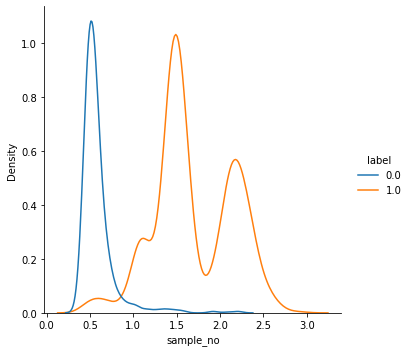

In [110]:
sns.displot(data=df_mean, x="sample_no", hue="label", kind="kde")

In [111]:
def plot_bubbles(data_subset, clust_size, Y_hue):
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(data_subset)
    fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1],
                     size=clust_size, color=Y_hue)
    fig.show()
    return tsne_results

In [112]:
X = df_mean[['col_'+str(i) for i in range(1,model_parameters.MULTIMODAL_SPACE_DIM+1)]].to_numpy()
Y_hue = df_mean['label'].to_numpy()
clust_size = df_mean['sample_no'].to_numpy()

In [113]:
X_2d = plot_bubbles(X, clust_size, Y_hue)

In [114]:
from sklearn.metrics.pairwise import euclidean_distances
ans = df_space.groupby(['sample_no']).apply(lambda x: euclidean_distances(x[['col_'+str(i) for i in range(1,model_parameters.MULTIMODAL_SPACE_DIM+1)]].to_numpy()))

In [115]:
ans[6]

array([[0.        , 4.08192562],
       [4.08192562, 0.        ]])

In [116]:
text_img1 = []
text_img2 = []
text_img3 = []
nb_imgs = []
for idx in range(ans.shape[0]):    
    nb_imgs.append(ans[idx].shape[0]-1)
    
    
    if ans[idx].shape[0] == 2: ## 1 image
        text_img1.append(ans[idx][0,1])
        text_img2.append(float("NaN"))
        text_img3.append(float("NaN"))
        
    elif ans[idx].shape[0] == 3: ## 2 images
        text_img1.append(ans[idx][0,1])
        text_img2.append(ans[idx][0,2])
        text_img3.append(float("NaN"))
        
    elif ans[idx].shape[0] == 4: ## 3 images
        text_img1.append(ans[idx][0,1])
        text_img2.append(ans[idx][0,2])
        text_img3.append(ans[idx][0,3])
        

df_dist = pd.DataFrame(columns=['text_img1', 'text_img2', 'text_img3', 'nb_imgs'])
df_dist['text_img1'] = text_img1
df_dist['text_img2'] = text_img2
df_dist['text_img3'] = text_img3


In [117]:
min_dist = df_dist.min(axis=1)
max_dist = df_dist.max(axis=1)

In [118]:
df_dist['nb_imgs'] = nb_imgs
df_dist['label'] = df_mean['label']

In [119]:
df_dist.head()

,text_img1,text_img2,text_img3,nb_imgs,label
0,3.868523,NaN,NaN,1,1.0
1,3.165833,3.073647,NaN,2,1.0
2,3.164420,3.026411,NaN,2,1.0
3,3.281689,3.194336,NaN,2,1.0
4,5.246633,NaN,NaN,1,1.0


In [120]:
df_dist['min_dist'] = min_dist
df_dist['max_dist'] = max_dist

In [121]:
df_dist['dif_dist'] = df_dist['max_dist'] -df_dist['min_dist']

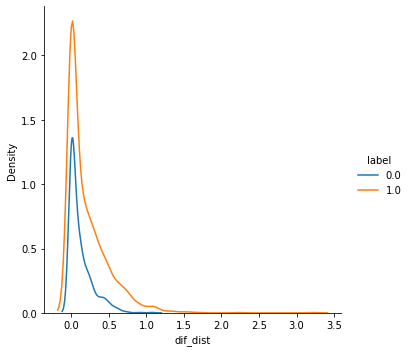

In [122]:
sns.displot(data=df_dist, x="dif_dist", hue="label", kind="kde")

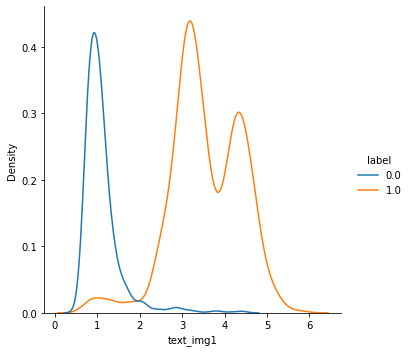

In [123]:
sns.displot(data=df_dist, x="text_img1", hue="label", kind="kde")

In [124]:
df_new_2 = pd.DataFrame(columns=["text_img1", "text_img2", "label"])
df_new_2['text_img1'] = df_dist["text_img1"]
df_new_2['text_img2'] = df_dist["text_img2"]
df_new_2['label'] = df_dist["label"]


df_new_2 = df_new_2.dropna()

array([<AxesSubplot:title={'center':'text_img1'}, xlabel='label'>,
       <AxesSubplot:title={'center':'text_img2'}, xlabel='label'>],
      dtype=object)

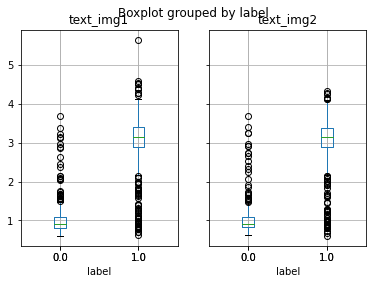

In [125]:
df_new_2.boxplot(column=["text_img1", "text_img2"], by='label')

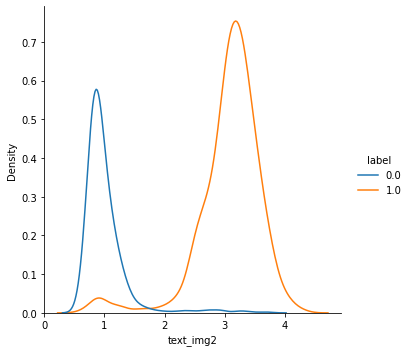

In [126]:
sns.displot(data=df_dist, x="text_img2", hue="label", kind="kde")

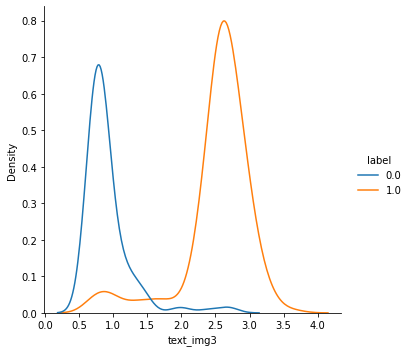

In [127]:
sns.displot(data=df_dist, x="text_img3", hue="label", kind="kde")

In [128]:
df_new_3 = pd.DataFrame(columns=["text_img1", "text_img2", "text_img3", "label"])
df_new_3['text_img1'] = df_dist["text_img1"]
df_new_3['text_img2'] = df_dist["text_img2"]
df_new_3['text_img3'] = df_dist["text_img3"]
df_new_3['label'] = df_dist["label"]


df_new_3 = df_new_3.dropna()

array([<AxesSubplot:title={'center':'text_img1'}, xlabel='label'>,
       <AxesSubplot:title={'center':'text_img2'}, xlabel='label'>,
       <AxesSubplot:title={'center':'text_img3'}, xlabel='label'>],
      dtype=object)

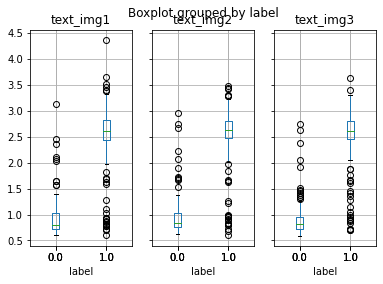

In [129]:
df_new_3.boxplot(column=["text_img1", "text_img2", "text_img3"], by='label', layout=(1, 3))